<a href="https://colab.research.google.com/github/heyday1006/2D-Lidar-DNN/blob/main/Laser_(361)_ResNet_Loop_Closure_Pose_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


# Section 1: Data Extraction

Data is saved to multiple csv files.

In [2]:
!gdown --id 1kMnzpnvonfZg-WBuzCO9QXhCRFb-6KXG #174lnAK9zW-L-vI7BgQPc42mVcVo7VWuv

Downloading...
From: https://drive.google.com/uc?id=1kMnzpnvonfZg-WBuzCO9QXhCRFb-6KXG
To: /content/pose0220.zip
1.43GB [00:15, 91.8MB/s]


In [3]:
import zipfile
dir_name='pose0220' #'data_pickle.zip'
local_zip = dir_name+'.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(dir_name)
zip_ref.close()

In [4]:
!pip3 install pickle5

     |████████████████████████████████| 133kB 16.0MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219249 sha256=f5775e17cd6348c122ff5a49cbb44a1e4fbdf107fca064d919ca10b8e19a7dbb
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [5]:
import pickle5 as pickle
def read_from_pickle(dir_name,type_name):
  with open(dir_name+'/'+dir_name+'/'+type_name+'_range_pairs.pickle', 'rb') as handle:
      range_pairs_all = pickle.load(handle)

  with open(dir_name+'/'+dir_name+'/'+type_name+'_pose_rels.pickle', 'rb') as handle:
      pose_rels_all = pickle.load(handle)
  range_pairs = np.swapaxes(range_pairs_all, 1, 2)
  translation_rels=np.round(np.double(pose_rels_all[:,0:2]),4)
  rotation_rels=np.double(pose_rels_all[:,2])
  range_pairs = range_pairs[:,::2,:]
  range_pairs = range_pairs[:,90:451,:]
  print("for %s dataset",type_name)
  print("size of range_pairs: ", range_pairs.shape)
  print("size of pose_rels: ", translation_rels.shape)
  print("size of rotation_rels: ", rotation_rels.shape)
  print("<------------->")
  return range_pairs,translation_rels,rotation_rels

range_pairs,pose_rels,rotation_rels = read_from_pickle(dir_name,'train')

for %s dataset train
size of range_pairs:  (147344, 361, 2)
size of pose_rels:  (147344, 2)
size of rotation_rels:  (147344,)
<------------->


## Remove inbalanced values

In [6]:
#too many zeros!!!
from numpy import linalg as LA
import math
# range_pairs = np.double(np.swapaxes(range_pairs_all, 1, 2))
# pose_rels=np.double(pose_rels_all[:,0:2])
# rotation_rels=np.double(pose_rels_all[:,2])

pose_rels_norm=LA.norm(pose_rels, axis=1)
nonzeros_indices=np.where((pose_rels_norm>1e-4) | (np.abs(rotation_rels)>1e-4))
nonfar_indices=np.where((rotation_rels<=1.0) & (rotation_rels>=-1.0) )
chosen_indices=np.intersect1d(nonzeros_indices,nonfar_indices)
pose_rels=pose_rels[chosen_indices]
rotation_rels=rotation_rels[chosen_indices]
range_pairs=range_pairs[chosen_indices]
print("size of pose_rels: ", pose_rels.shape)

size of pose_rels:  (127570, 2)


## Convert to grid coordinates

In [7]:
print(min(pose_rels[:,0]),max(pose_rels[:,0]))
print(min(pose_rels[:,1]),max(pose_rels[:,1]))
#discretize the values
grid_offset=np.array([-1.8,-1.2])
grid_spacing=np.array([0.05,0.05])
grid_indices=np.round((np.array(pose_rels)-grid_offset)/grid_spacing)
pose_rels_grid=np.array(grid_indices)
print(np.shape(pose_rels_grid))
pose_rels_grid=pose_rels_grid.astype(int)


-1.7247 1.6685
-0.9242 0.7726
(127570, 2)


In [8]:
# with rotations
rotation_gridspace=0.5
rotation_rels=np.round(np.double(rotation_rels*180/math.pi),4)
rotation_rels_grid=np.array(np.round((np.array(rotation_rels)-np.array([-1.0*180/math.pi]))/rotation_gridspace))
rotation_rels_grid=rotation_rels_grid.astype(int)

## Check discretized label distributions 

Visualize the distribution of discretized values

70 40 (2786,)


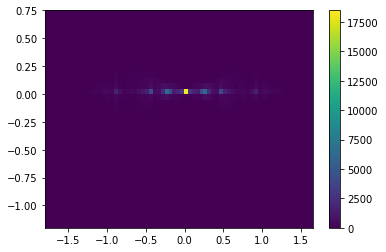

In [9]:
pose_rels_1d=pose_rels_grid[:,0]*(np.max(pose_rels_grid[:,1])+1)+pose_rels_grid[:,1]
pose_rels_1d_bincount=np.bincount((pose_rels_1d).astype(int))
x_dim=np.int(np.max(pose_rels_grid[:,0])+1)
y_dim=np.int(np.max(pose_rels_grid[:,1])+1)
pose_rels_1d_bincount_full=np.zeros(x_dim*y_dim)
pose_rels_1d_bincount_full[:len(pose_rels_1d_bincount)]=pose_rels_1d_bincount
print(x_dim,y_dim,np.shape(pose_rels_1d_bincount))
pose_rels_2d_bincount=np.reshape(pose_rels_1d_bincount_full, [x_dim,-1], order='C')
#setup the 2D grid with Numpy
x_grid, y_grid = np.meshgrid(np.arange(-1.8,1.7,0.05), np.arange(-1.2,0.8,0.05))
#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(pose_rels_2d_bincount)
#now just plug the data into pcolormesh, it's that easy!
plt.pcolormesh(x_grid, y_grid, np.swapaxes(intensity,0,1))
plt.colorbar() #need a colorbar to show the intensity scale
plt.show() #boom


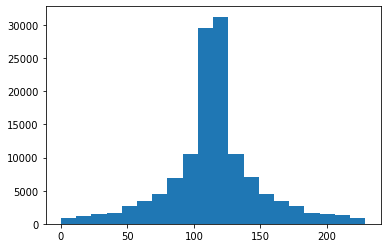

In [10]:
#rotation
plt.hist(rotation_rels_grid,bins=20);

In [11]:
pose_rels_grid=pose_rels_1d
print(np.max(pose_rels_grid))
print(np.max(rotation_rels_grid))

2785
229


## Compressive Sensing

In [12]:
x=np.array([[1,2,3],[3,4,5]])
y=np.array([0,1])
mask = np.ones(x.shape,dtype=bool) #np.ones_like(a,dtype=bool)
mask[:,y] = False
x[mask] = 999
print(x)

[[  1   2 999]
 [  3   4 999]]


In [15]:
import random
# Flag_compression=False
# if Flag_compression:
#   percent_compresed=0.1
#   indices_pre=np.array(random.sample(range(1,539),np.int(1079*percent_compresed/2)))
#   indices_pre=np.append(2*indices_pre,2*indices_pre+1)
#   print(np.shape(indices_pre))
#   indices=np.array(np.append(1,np.sort(indices_pre),1081))
#   range_pairs_compressed=np.array(range_pairs.copy())#=range_pairs[:,indices,:]
#   mask=np.ones(range_pairs_compressed.shape,dtype=bool)
#   mask[:,indices,:]=False
#   range_pairs_compressed[mask]=0
# else:
#   range_pairs_compressed=range_pairs

#   print("size of range_pairs_compressed: ", range_pairs_compressed.shape)
Flag_compression=True
Karaman_method = False
def laser_compression(range_pairs,Flag_compression,Karaman_method):
  if Flag_compression:
    percent_compressed=0.5
    range_pairs_compressed=np.array(range_pairs.copy())#=range_pairs[:,indices,:]
    mask=np.ones(range_pairs_compressed.shape,dtype=bool)
    if Karaman_method:
      indices_pre=np.array(random.sample(range(1,539),np.int(1079*percent_compresed/2)))
      indices_pre=np.append(2*indices_pre,2*indices_pre+1)
      print(np.shape(indices_pre))
      indices=np.array(np.append(1,np.sort(indices_pre),1081))
      mask[:,indices,:]=False
    else:
      # for irow in range(2):
        for isample in range(range_pairs_compressed.shape[0]):
          indices=np.random.choice(range(361),np.int(361*percent_compressed))
          # print(indices)
          mask[isample,indices,:]=False
    range_pairs_compressed[mask]=0
    range_pairs_compressed = np.concatenate((range_pairs_compressed,np.double(mask[:,:,0])[:,:,np.newaxis]),axis=-1)
  else:
    range_pairs_compressed=range_pairs

  print("size of range_pairs_compressed: ", range_pairs_compressed.shape)
  return range_pairs_compressed
range_pairs_compressed = laser_compression(range_pairs,Flag_compression,Karaman_method)
  

size of range_pairs_compressed:  (127570, 361, 3)


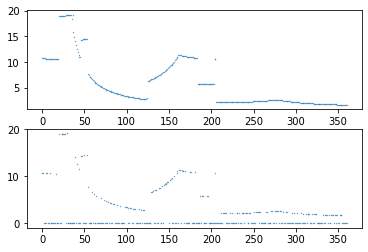

In [16]:
plt.figure(1)
plt.subplot(211)
plt.scatter([range(361)], [range_pairs[500,:,1]], s=0.1, label="original")
plt.subplot(212)
plt.scatter([range(361)], [range_pairs_compressed[500,:,1]], s=0.1, label="compressive")
# if Flag_compression:
#   for xc in indices:
#     plt.axvline(x=xc,c='r',linewidth=0.1,linestyle='-.')
    
plt.show()

# Section 2: Data Preparation

In [17]:
from sklearn.utils import shuffle
#pose_rels_grid_all=np.hstack((np.expand_dims(pose_rels_grid, axis=1),np.expand_dims(rotation_rels, axis=1)))
pose_rels_value_all=np.hstack((pose_rels,np.expand_dims(rotation_rels, axis=1)))
#print(np.shape(range_pairs_compressed),np.shape(pose_rels_grid),np.shape(rotation_rels_grid),np.shape(pose_rels_grid_all),np.shape(pose_rels_all))
xs, ys, ys_ground_truth = shuffle(range_pairs_compressed, pose_rels_value_all, pose_rels_value_all) #shuffling the dataset
xs=np.clip(xs, a_min=None, a_max=40)    #remove the inf value of range to a large number

percent_of_trainSet=0.99*0.85
percent_of_validationSet=0.99*0.15
percent_of_testSet=0.01
num_of_trainSet=np.int(ys.shape[0]*percent_of_trainSet)
num_of_validationSet=np.int(ys.shape[0]*percent_of_validationSet)
num_of_testSet=np.int(ys.shape[0]*percent_of_testSet)

x_training = np.array(xs[0:num_of_trainSet], dtype=float)
y_training = np.array(ys[0:num_of_trainSet], dtype=float)
y_training_ground_truth = np.array(ys_ground_truth[0:num_of_trainSet], dtype=float)
print('Size of training data: ', x_training.shape)
print('Size of training labels: ',y_training.shape)

x_validation = np.array(xs[num_of_trainSet:num_of_trainSet+num_of_validationSet], dtype=float)
y_validation = np.array(ys[num_of_trainSet:num_of_trainSet+num_of_validationSet], dtype=float)
y_validation_ground_truth = np.array(ys_ground_truth[num_of_trainSet:num_of_trainSet+num_of_validationSet], dtype=float)
print('Size of validation data: ', x_validation.shape)
print('Size of validation labels: ',y_validation.shape)

x_testing = np.array(xs[num_of_trainSet+num_of_validationSet:], dtype=float)
y_testing = np.array(ys[num_of_trainSet+num_of_validationSet:], dtype=float)
y_testing_ground_truth=np.array(ys_ground_truth[num_of_trainSet+num_of_validationSet:], dtype=float)
print('Size of testing data: ', x_testing.shape)
print('Size of testing labels: ',y_testing.shape)

Size of training data:  (107350, 361, 3)
Size of training labels:  (107350, 3)
Size of validation data:  (18944, 361, 3)
Size of validation labels:  (18944, 3)
Size of testing data:  (1276, 361, 3)
Size of testing labels:  (1276, 3)


# Section 3: Model Traning

In [18]:
BATCH_SIZE = 32
training_dataset = tf.data.Dataset.from_tensor_slices((x_training,(y_training[:,0:2],y_training[:,2]))).batch(BATCH_SIZE)#
validation_dataset = tf.data.Dataset.from_tensor_slices((x_validation, (y_validation[:,0:2],y_validation[:,2]))).batch(BATCH_SIZE)

In [19]:
from tensorflow.keras.layers import Input, Conv1D, Activation, MaxPooling1D, Add, AveragePooling1D, Dense, Dropout, Flatten
from tensorflow.keras import Model
def residual_block(x):
      temp = x
      x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
      x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
      x = Add()([Activation('relu')(x), temp])
      return x

class SoftArgmax(tf.keras.layers.Layer):
    def __init__(self, name):
        super(SoftArgmax, self).__init__()
        self._name = name
    
    def call(self, input):
        # range
        x = input
        input_size=tf.shape(input)
        pos = tf.convert_to_tensor(range(input_size[1]),dtype=tf.float32)
        x *= pos
        x = tf.reduce_sum(x, axis=1, keepdims=True)
        return x

def Res1DFlat(dropout_rate,input_shape):
  # input size = (batch_size, 2, 1081)
  input_data = Input(shape=input_shape)
  #x = Dense(1024, activation='relu')(1081)
  # first resnet block
  x = Conv1D(filters=64, kernel_size=7, strides=3, activation='relu', padding='same')(input_data)
  x = MaxPooling1D(pool_size=3)(x)
  x=residual_block(x)
  # second resnet block
  x=residual_block(x)
  # third resnet block
  x=residual_block(x)
  # fourth resnet block
  x=residual_block(x)
  # fifth resnet block
  x=residual_block(x)

  # Average pooling
  x = AveragePooling1D(pool_size=7)(x)
  x = Flatten()(x) # (batch_size, 2, channel)

  # Dense Layers
  x = Dense(1024, activation='relu')(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(dropout_rate)(x)

  x1 = Dense(512, activation='relu')(x)
  x1 = Dropout(dropout_rate)(x1)
  #output1 = Dense(2786, activation='softmax', name='pose')(x1)
  output1 = Dense(2, activation=None, name='pose')(x1)

  x2 = Dense(512, activation='relu')(x)
  x2 = Dropout(dropout_rate)(x2)
  output2 = Dense(1, activation=None,name='rotation')(x2)
  #x2 = Dense(230, activation='softmax')(x2)
  #output2 = SoftArgmax(name='rotation')(x2,10)#Dense(230, activation='softmax', name='rotation')(x2)

  model = Model(inputs=input_data, outputs=[output1, output2])
  return model


check if the soft-argmax function is working

In [20]:
x = tf.convert_to_tensor([[0.2, 0.3, 0.5],[0.1,0.3,0.6]])
#x = tf.nn.softmax(x)
x = SoftArgmax(name='trial')(x)
x

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.3],
       [1.5]], dtype=float32)>

In [21]:
import tensorflow.keras.backend as kb
from tensorflow.keras.losses import MSE
from tensorflow import stack,argmax,cast

dropout_rate=0.2
optimizer_lr=0.001
model = Res1DFlat(dropout_rate,np.shape(x_training[0]))
optimizer = tf.keras.optimizers.Adam(optimizer_lr)
model.compile(optimizer=optimizer,
              loss={"pose": keras.losses.mse, "rotation": keras.losses.mse},#sparse_categorical_crossentropy,losses.mse},
              loss_weights=[10.0, 0.05],
              metrics={"pose": tf.keras.metrics.MeanAbsoluteError(), "rotation": tf.keras.metrics.MeanAbsoluteError()})#SparseCategoricalAccuracy,MeanAbsoluteError()})
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 361, 3)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 121, 64)      1408        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 40, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 40, 64)       12352       max_pooling1d[0][0]              
______________________________________________________________________________________________

In [22]:
# lr decay function
def lr_decay(epoch):
  return 0.001 * math.pow(0.9, np.floor(epoch/5))
# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

EPOCHS=100
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_pose_mean_absolute_error', mode='min', patience=7, restore_best_weights=True, verbose=1)
model.fit(training_dataset, validation_data=validation_dataset, epochs=EPOCHS, callbacks=[early_stopper,lr_decay_callback])

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
3355/3355 [==============================] - 39s 7ms/step - loss: 13.7256 - pose_loss: 0.3538 - rotation_loss: 203.7589 - pose_mean_absolute_error: 0.2645 - rotation_mean_absolute_error: 9.0435 - val_loss: 4.5361 - val_pose_loss: 0.0949 - val_rotation_loss: 71.7356 - val_pose_mean_absolute_error: 0.1781 - val_rotation_mean_absolute_error: 4.7529
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
3355/3355 [==============================] - 22s 7ms/step - loss: 4.5408 - pose_loss: 0.0875 - rotation_loss: 73.3195 - pose_mean_absolute_error: 0.1722 - rotation_mean_absolute_error: 4.9211 - val_loss: 2.8651 - val_pose_loss: 0.0633 - val_rotation_loss: 44.6412 - val_pose_mean_absolute_error: 0.1399 - val_rotation_mean_absolute_error: 3.5669
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
3355/3355 [==============================] - 22s 7ms/step - los

# Section 4: Model Evaluation

In [23]:
model.evaluate(validation_dataset)

592/592 [==============================] - 2s 3ms/step - loss: 0.2178 - pose_loss: 0.0049 - rotation_loss: 3.3811 - pose_mean_absolute_error: 0.0350 - rotation_mean_absolute_error: 0.9631


[0.2178233563899994,
 0.004876597318798304,
 3.381148338317871,
 0.03500441834330559,
 0.9630863070487976]

In [ ]:
# model.save("model_regression")
# from google.colab import files
# !zip -r model_regression.zip model_regression/
# files.download('model_regression.zip')

In [24]:
#evaluate model accuracy using testing dataset
testing_dataset = tf.data.Dataset.from_tensor_slices((x_testing, (y_testing[:,0:2],y_testing[:,2]))).batch(BATCH_SIZE)
model.evaluate(testing_dataset)

40/40 [==============================] - 0s 3ms/step - loss: 0.1600 - pose_loss: 0.0041 - rotation_loss: 2.3720 - pose_mean_absolute_error: 0.0350 - rotation_mean_absolute_error: 0.9611


[0.16004642844200134,
 0.004144479054957628,
 2.372032642364502,
 0.03504437580704689,
 0.9611061811447144]

## Test from new environment

In [27]:
testing_range_pairs,testing_translation_rels,testing_rotation_rels = read_from_pickle(dir_name,'test')

testing_translation_rels_norm=LA.norm(testing_translation_rels, axis=1)
testing_nonzeros_indices=np.where((testing_translation_rels_norm>1e-4) | (np.abs(testing_rotation_rels)>1e-4))
testing_nonfar_indices=np.where((testing_rotation_rels<=1.0) & (testing_rotation_rels>=-1.0))
testing_chosen_indices=np.intersect1d(testing_nonzeros_indices,testing_nonfar_indices)
testing_translation_rels=testing_translation_rels[testing_chosen_indices]
testing_rotation_rels=testing_rotation_rels[testing_chosen_indices]
testing_range_pairs=laser_compression(testing_range_pairs[testing_chosen_indices],Flag_compression,Karaman_method)

testing_rotation_rels=np.round(np.double(testing_rotation_rels*180/math.pi),4)
#pose_rels_grid_all=np.hstack((np.expand_dims(pose_rels_grid, axis=1),np.expand_dims(rotation_rels, axis=1)))
testing_pose_rels_all=np.hstack((testing_translation_rels,np.expand_dims(testing_rotation_rels, axis=1)))
#print(np.shape(range_pairs_compressed),np.shape(pose_rels_grid),np.shape(rotation_rels_grid),np.shape(pose_rels_grid_all),np.shape(pose_rels_all))
testing_range_pairs_all=np.clip(testing_range_pairs, a_min=None, a_max=40)    #remove the inf value of range to a large number

x_test_new, y_test_new, y_test_new_ground_truth = shuffle(testing_range_pairs_all,testing_pose_rels_all, testing_pose_rels_all)

x_testing2 = np.array(x_test_new, dtype=float)
y_testing2 = np.array(y_test_new, dtype=float)
y_testing_ground_truth2=np.array(y_test_new, dtype=float)
print('Size of testing data: ', x_testing2.shape)
print('Size of testing labels: ',y_testing2.shape)
testing_dataset2 = tf.data.Dataset.from_tensor_slices((x_testing2, (y_testing2[:,0:2],y_testing2[:,2]))).batch(BATCH_SIZE)
model.evaluate(testing_dataset2)

for %s dataset test
size of range_pairs:  (24562, 361, 2)
size of pose_rels:  (24562, 2)
size of rotation_rels:  (24562,)
<------------->
size of range_pairs_compressed:  (18556, 361, 3)
Size of testing data:  (18556, 361, 3)
Size of testing labels:  (18556, 3)
580/580 [==============================] - 2s 3ms/step - loss: 1.3157 - pose_loss: 0.0234 - rotation_loss: 21.6241 - pose_mean_absolute_error: 0.0777 - rotation_mean_absolute_error: 1.8165


[1.3156551122665405,
 0.023445308208465576,
 21.62406349182129,
 0.07768901437520981,
 1.8165488243103027]

In [28]:
y_testing3=y_testing2
x_testing3=x_testing2
y_testing_ground_truth3=y_testing_ground_truth2

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import MAE
def inverse_projection_2d(predict_idx):
  y_idx=predict_idx%40
  x_idx=(predict_idx-y_idx)/40
  grid_offset=np.transpose(np.array([[-1.8,-1.2]]))
  grid_spacing=np.transpose(np.array([[0.05,0.05]]))
  grid_point=grid_offset+np.array([x_idx,y_idx])*grid_spacing
  return grid_point

def inverse_projection_1d(predict_idx):
  grid_offset=np.array([-1.0*180/np.pi])
  grid_spacing=np.array([0.5])
  grid_point=grid_offset+predict_idx*grid_spacing
  print(grid_point[0:2])
  print(predict_idx[0:2])
  return grid_point


y_predict=model.predict(x_testing3)

print(y_predict[0].shape, y_predict[1].shape, y_testing3[:,2].shape,y_testing3[:,0:2].shape)
# predict_pose=np.argmax(y_predict[0],axis=1)
# predict_pose_point=np.transpose(inverse_projection_2d(predict_pose))
predict_pose_point=y_predict[0]


# predict_rotation=np.argmax(y_predict[1],axis=1)
# predict_rotation_value=np.transpose(inverse_projection_1d(predict_rotation))
predict_rotation_value=tf.squeeze(y_predict[1])
  

# print(np.shape(predict_rotation))
print("prediction of translation MSE: ", tf.reduce_sum(MAE(y_testing3[:,0:2],predict_pose_point))/y_testing3.shape[0])
print("prediction of rotation MAE: ", MAE(y_testing3[:,2], predict_rotation_value))
nSamples=200
predict_list=np.zeros((nSamples,3))
for i in range(nSamples):
  predict_i=list(np.round(predict_pose_point[i],4))
  predict_i.append(np.round(np.float(predict_rotation_value[i]),4))
  predict_list[i]=predict_i
  if i%1==0:
    print("test: ", i, " ground_truth: ", np.round(y_testing_ground_truth3[i],4),
          " predicted: ",predict_i)


(18556, 2) (18556, 1) (18556,) (18556, 2)
prediction of translation MSE:  tf.Tensor(0.07768898, shape=(), dtype=float32)
prediction of rotation MAE:  tf.Tensor(1.8165494, shape=(), dtype=float32)
test:  0  ground_truth:  [ 0.9869 -0.0212 -5.8844]  predicted:  [0.8993, -0.0093, -5.5503]
test:  1  ground_truth:  [-0.9056 -0.1478 38.1943]  predicted:  [-0.4548, -0.1154, 32.5009]
test:  2  ground_truth:  [-2.43000e-02 -5.80000e-03  5.22559e+01]  predicted:  [0.0706, 0.052, 51.4674]
test:  3  ground_truth:  [-0.     0.    44.537]  predicted:  [-0.0331, -0.009, 41.1507]
test:  4  ground_truth:  [0.7516 0.0078 2.3732]  predicted:  [0.8417, 0.0318, 2.8466]
test:  5  ground_truth:  [ 0.3415 -0.001  -0.433 ]  predicted:  [0.3077, 0.0019, -1.3143]
test:  6  ground_truth:  [-0.2977 -0.0011  0.4207]  predicted:  [-0.2198, -0.0032, -0.3102]
test:  7  ground_truth:  [  0.6244  -0.169  -30.836 ]  predicted:  [0.5051, -0.0821, -25.2869]
test:  8  ground_truth:  [ 4.5030e-01 -1.1000e-03 -1.3744e+00]  pr

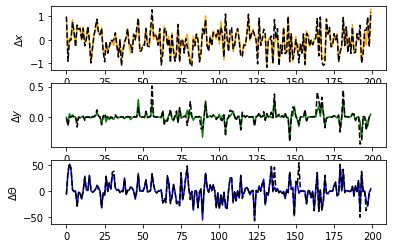

In [30]:
t=range(nSamples)
plt.figure()
plt.subplot(311)
plt.plot(t, predict_list[:,0], color='orange')
plt.plot(t, y_testing_ground_truth3[0:nSamples,0], color='black',linestyle='--')
plt.ylabel('$\Delta x$')

plt.subplot(312)
plt.plot(t, predict_list[:,1], color='green')
plt.plot(t, y_testing_ground_truth3[0:nSamples,1], color='black',linestyle='--')
plt.ylabel('$\Delta y$')

plt.subplot(313)
plt.plot(t, predict_list[:,2], color='blue')
plt.plot(t, y_testing_ground_truth3[0:nSamples,2], color='black',linestyle='--')
plt.ylabel('$\Delta \Theta$')
#plt.legend(['predicted','ground_truth'])
plt.show()

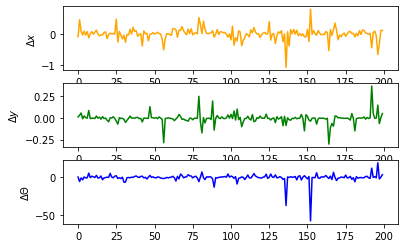

In [31]:
# errors
t=range(nSamples)
plt.figure()
plt.subplot(311)
plt.plot(t, predict_list[:,0]-y_testing_ground_truth3[0:nSamples,0], color='orange')
plt.ylabel('$\Delta x$')

plt.subplot(312)
plt.plot(t, predict_list[:,1]-y_testing_ground_truth3[0:nSamples,1], color='green')
plt.ylabel('$\Delta y$')

plt.subplot(313)
plt.plot(t, predict_list[:,2]-y_testing_ground_truth3[0:nSamples,2], color='blue')
plt.ylabel('$\Delta \Theta$')
#plt.legend(['predicted','ground_truth'])
plt.show()

## with additional sensor noise

In [32]:
x_testing2_noise=x_testing2+np.random.normal(0,0.05,np.shape(x_testing2))
testing_dataset_noise = tf.data.Dataset.from_tensor_slices((x_testing2_noise, (y_testing2[:,0:2],y_testing2[:,2]))).batch(BATCH_SIZE)
model.evaluate(testing_dataset_noise)

580/580 [==============================] - 2s 3ms/step - loss: 1.3748 - pose_loss: 0.0249 - rotation_loss: 22.5113 - pose_mean_absolute_error: 0.0813 - rotation_mean_absolute_error: 1.8953


[1.3748443126678467,
 0.024927804246544838,
 22.511335372924805,
 0.08133412897586823,
 1.8953410387039185]

## Visualize feature map

In [ ]:
# kernels in first conv layer
filters, biases = model.layers[1].get_weights()
print(np.shape(filters))
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.plot(filters[:,0,ix-1])
		ix += 1
# show the figure
plt.show()

In [ ]:
# define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# run our image through our network, thus obtaining all
# intermediate representations for this range data.
successive_feature_maps = visualization_model.predict(x_training[0:5])
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
visualization_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
feature_maps = visualization_model.predict(np.expand_dims(x_training[500], axis=0))
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.plot(feature_maps[0, :, ix-1])
		ix += 1
# show the figure
plt.show()

## Odometry-based Localization

In [33]:
!gdown --id 1Jq9xPARjAEY8DmJL0Q5uvFSOVHo-bwkf #simple wall
#!gdown --id 1IyOf-VK_8eqDl00seI36Eo_FIcThVqio #simple maze:
world_name = 'simple_wall'
local_zip = 'test_'+world_name+'.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('test_'+world_name)
zip_ref.close()

Downloading...
From: https://drive.google.com/uc?id=1Jq9xPARjAEY8DmJL0Q5uvFSOVHo-bwkf
To: /content/test_simple_wall.zip
100% 1.66M/1.66M [00:00<00:00, 107MB/s]


In [35]:
with open('test_'+world_name+'/test_simple_range_pairs_3.pickle', 'rb') as handle:
    test_simple_range_pairs = pickle.load(handle)

with open('test_'+world_name+'/test_simple_pose_rels_3.pickle', 'rb') as handle:
    test_simple_pose_rels = pickle.load(handle)
test_simple_range_pairs = np.swapaxes(test_simple_range_pairs, 1, 2)
test_simple_range_pairs = test_simple_range_pairs[:,::2,:]
test_simple_range_pairs = laser_compression(test_simple_range_pairs[:,90:451,:],Flag_compression,Karaman_method)
test_simple_translation_rels=test_simple_pose_rels[:,0:2]
test_simple_rotation_rels=test_simple_pose_rels[:,2]
print("size of range_pairs: ", test_simple_range_pairs.shape)
print("size of pose_rels: ", test_simple_translation_rels.shape)
print("size of rotation_rels: ", test_simple_rotation_rels.shape)

size of range_pairs_compressed:  (243, 361, 3)
size of range_pairs:  (243, 361, 3)
size of pose_rels:  (243, 2)
size of rotation_rels:  (243,)


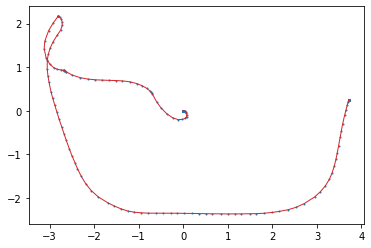

In [36]:
from matplotlib.animation import FuncAnimation
def rels_to_abs(pose_rels):
    pose_i = np.array([[0],[0]])
    poses = pose_i.T
    theta_i = 0.0
    for i in range(pose_rels.shape[0]):
        [rels_x,rels_y,rels_theta] = pose_rels[i,0:3]
        T_matrix = np.array([[np.cos(theta_i),-np.sin(theta_i)],[np.sin(theta_i),np.cos(theta_i)]])
        pose_ic =np.dot(T_matrix,np.array([[rels_x],[rels_y]]))+pose_i
        poses = np.concatenate((poses,pose_ic.T))
        pose_i = pose_ic
        if isinstance(rels_theta,np.ndarray):
          theta_i += rels_theta[0,0]
        else:
          theta_i += rels_theta
    return poses

dataSet = rels_to_abs(np.array(test_simple_pose_rels))
plt.plot(dataSet[:,0],dataSet[:,1], 'C3', lw=1)
plt.scatter(dataSet[:,0],dataSet[:,1], s=1)


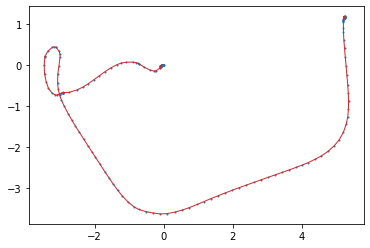

In [37]:
from matplotlib.animation import FuncAnimation
test_pose_predict=model.predict(test_simple_range_pairs[0:-1,:])
predict_test_translation_value = np.array(test_pose_predict[0])
predict_test_rotation_value=np.expand_dims(np.array(tf.squeeze(test_pose_predict[1])), axis=1)*np.pi/180
predict_test_pose = np.concatenate((predict_test_translation_value,predict_test_rotation_value),axis=-1)
dataSet_estimate = rels_to_abs(np.array(predict_test_pose))
# dataSet_ground_truth = rels_to_abs(np.array(test_simple_pose_rels))
plt.plot(dataSet_estimate[:,0],dataSet_estimate[:,1], 'C3', lw=1)
plt.scatter(dataSet_estimate[:,0],dataSet_estimate[:,1], s=1)

compare ground-truth trajectory with predicted trajector

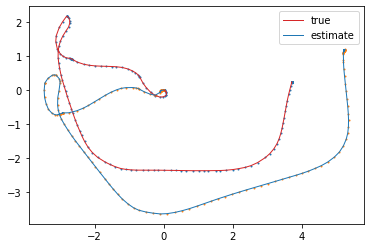

In [40]:
plt.plot(dataSet[:,0],dataSet[:,1], 'C3', lw=1, label='true')
plt.scatter(dataSet[:,0],dataSet[:,1], s=1)

plt.plot(dataSet_estimate[:,0],dataSet_estimate[:,1], 'C10', lw=1, label='estimate')
plt.scatter(dataSet_estimate[:,0],dataSet_estimate[:,1], s=1)

plt.legend(loc='upper right')

In [41]:
for i in range(100):
  predict_i=list(np.round(predict_test_translation_value[i],4))
  predict_i.append(np.round(np.float(predict_test_rotation_value[i]),4))
  if i%1==0:
    print("test: ", i, " ground_truth: ", np.round(np.double(test_simple_pose_rels[i,:]),4),
          " predicted: ",predict_i)

test:  0  ground_truth:  [-0. -0.  0.]  predicted:  [-0.003, -0.0002, 0.0144]
test:  1  ground_truth:  [ 0. -0.  0.]  predicted:  [-0.0035, -1e-04, 0.008]
test:  2  ground_truth:  [0. 0. 0.]  predicted:  [-0.003, -1e-04, -0.0112]
test:  3  ground_truth:  [-0.  0.  0.]  predicted:  [-0.0028, -0.0002, -0.0034]
test:  4  ground_truth:  [-0. -0.  0.]  predicted:  [-0.003, -0.0002, 0.0054]
test:  5  ground_truth:  [0. 0. 0.]  predicted:  [-0.0033, -1e-04, -0.0133]
test:  6  ground_truth:  [-0.  0.  0.]  predicted:  [-0.0043, -1e-04, 0.0136]
test:  7  ground_truth:  [-0. -0.  0.]  predicted:  [0.0012, -0.0004, 0.0137]
test:  8  ground_truth:  [0. 0. 0.]  predicted:  [0.0012, -0.0003, 0.0173]
test:  9  ground_truth:  [-0.  0.  0.]  predicted:  [-0.0026, -0.0002, -0.0031]
test:  10  ground_truth:  [0. 0. 0.]  predicted:  [-0.0002, -0.0003, 0.0171]
test:  11  ground_truth:  [-0.  0.  0.]  predicted:  [-0.005, -1e-04, -0.0045]
test:  12  ground_truth:  [-0. -0.  0.]  predicted:  [-0.004, -1e-04,

# Section 5: Load Saved Model

In [ ]:
model.save_weights('./model_weights_0404_361samples/base_model_weights', save_format='tf')
!zip -r model_weights_0404_361samples.zip model_weights_0404_361samples/

In [ ]:
from google.colab import files
files.download('model_weights_0404_361samples.zip')